# Digit Recognition
Learning enough keras to recognise digits

Approach is mostly based on the [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) guide. I added another dense layer. It seemed to improve things, and this way I can claim 

Using [TMNIST](https://www.kaggle.com/datasets/nimishmagre/tmnist-typeface-mnist) here, as we're more likely to see printed fonts than handwritten ones. Could be fun in the future to distinguish between printed and handwritten as a way of "checking" if the user is correct so far... but lets stick with baby steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-06-04 22:18:10.502086: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 22:18:10.536751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("TMNIST_DATA.csv")
df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,Raleway[wght],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,Charm-Regular,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,BigShouldersStencilDisplay-Black,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,Gabriela-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
digits = df.drop(["names", "labels"], axis=1)
labels = df["labels"]

digits = digits.to_numpy().reshape(-1, 28, 28, 1) / 255
labels = labels.to_numpy()

print("digits shape:", digits.shape)
print("labels shape:", labels.shape)

digits shape: (29900, 28, 28, 1)
labels shape: (29900,)


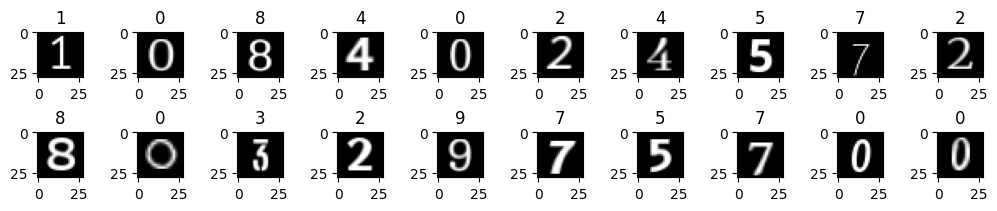

In [4]:
def view(digits, labels, rows=1, cols=10, title=None):
    fig, subs = plt.subplots(rows, cols, layout='constrained', figsize=(cols,rows + (0.25 if title else 0)), squeeze=False)
    if title:
        fig.suptitle(title)
    subs = [s for sub in subs for s in sub] 
    for digit, label, sub in zip(digits, labels, subs):
        sub.set_title(label)
        sub.imshow(digit, cmap='gray')

samples = np.random.choice(len(digits), 20)

view(digits[samples], labels[samples], rows=2)

2024-06-04 22:18:14.076241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 22:18:14.081129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 22:18:14.081155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 22:18:14.084317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 22:18:14.084346: I external/local_xla/xla/stream_executor

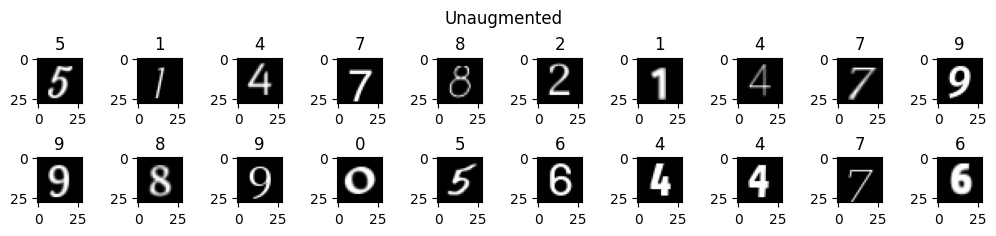

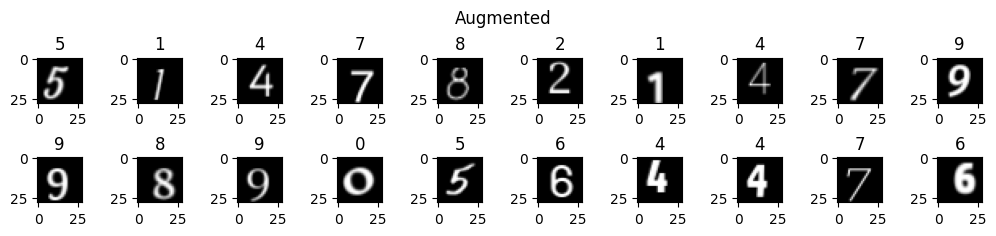

In [5]:
# Rotating and zooming results in really blurry numbers at this size.
# Rotation is probably pointless anyway, since we should end up with characters mostly at some multiple of 90 deg after morphing the image,
# so we can just move them around a bit to create more data (I have no idea if this is a good practice or not...)
augmentations = keras.Sequential([
    # layers.RandomRotation(0.025),
    # layers.RandomZoom((-0.2, 0.2), (-0.2, 0.2), fill_mode="constant", fill_value=0),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), fill_mode="constant", fill_value=0),
])

samples = np.random.choice(len(digits), 20)

augmented_digits = augmentations(digits[samples])

view(digits[samples], labels[samples], title="Unaugmented", rows=2)
view(augmented_digits, labels[samples], title="Augmented", rows=2)

In [6]:
x = np.concatenate([digits] + [augmentations(digits) for _ in range(9)])
y = np.concatenate([labels for _ in range(10)])

p = np.random.permutation(len(x))
x = x[p]
y = y[p]

print("Digits after augmentation:", len(x))

Digits after augmentation: 299000


In [7]:
TRAINING_SET = 0.8
r = np.random.default_rng(seed=12345)
training_mask = np.fromiter((r.random() <= TRAINING_SET for _ in range(len(x))), dtype=bool)

x_train = x[training_mask]
x_test = x[~training_mask]

y_train = keras.utils.to_categorical(y[training_mask], 10)
y_test = keras.utils.to_categorical(y[~training_mask], 10)

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 239017
Test samples: 59983


In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15


I0000 00:00:1717539501.580300     564 service.cc:145] XLA service 0xceb5950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717539501.580359     564 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-04 22:18:21.603340: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 22:18:21.712144: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  95/1681 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3560 - loss: 1.8010

I0000 00:00:1717539504.466565     564 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1681/1681 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8293 - loss: 0.5210 - val_accuracy: 0.9873 - val_loss: 0.0450
Epoch 2/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9736 - loss: 0.0929 - val_accuracy: 0.9897 - val_loss: 0.0350
Epoch 3/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9804 - loss: 0.0680 - val_accuracy: 0.9919 - val_loss: 0.0265
Epoch 4/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9835 - loss: 0.0550 - val_accuracy: 0.9923 - val_loss: 0.0245
Epoch 5/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9849 - loss: 0.0502 - val_accuracy: 0.9935 - val_loss: 0.0211
Epoch 6/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9860 - loss: 0.0456 - val_accuracy: 0.9930 - val_loss: 0.0212
Epoch 7/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9867 - loss: 0.0438 - val_accuracy: 0.9946 - val_loss: 0.0181
Epoch 8/15
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9873 - loss: 0.0409 - val_accurac

In [10]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9967 - loss: 0.0102
Test loss: 0.01131321582943201
Test accuracy: 0.9961655735969543


In [11]:
import time
model.save(f"models/digits_{int(score[1] * 10000)}_{int(time.time())}.keras")